## Import necessary modules, set up environment

In [1]:

from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
import gymnasium



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [6]:
def no_zeros(l):
    out = []
    for elt in l:
        if elt != 0:
            out.append(elt)
        else:
            return out

In [7]:

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
ob1, info = env.reset()
env = DictObservationSpaceWrapper(env)
ob2, info = env.reset()



print(ob1['mission'])
print(no_zeros(ob2['mission']))

for i in range(100):

    action = env.action_space.sample()

    ob3, reward, term, truc, info = env.step(action)
    print(no_zeros(ob3['mission']))
    print(reward)


get the green key from the blue room, unlock the green door and go to the goal
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 38, 31, 15]
0
[20, 31, 5, 12, 49, 31, 4, 50, 34, 28, 31, 5, 14, 36, 25, 3

In [12]:
ob2['mission'].long()

AttributeError: 'list' object has no attribute 'long'

In [30]:
# torch.nn.functional.one_hot(ob2.long(), num_classes=int(env.observation_space['mission'].nvec[idx])).float()
num_classes = env.observation_space['mission'].nvec[32]
classes = torch.split(torch.Tensor(ob2['mission']).long().unsqueeze(0), 1, dim=1)[32].long()

print(torch.nn.functional.one_hot(classes, num_classes=num_classes).float())


tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [47]:
from stable_baselines3.common.preprocessing import preprocess_obs

ob = torch.Tensor([ob2['mission']])
ob_space = env.observation_space['mission']
print(ob[0, 7], ob_space)
print(ob1['mission'])

preprocess_obs(ob, ob_space)

tensor(50.) MultiDiscrete([50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50])
get the green key from the blue room, unlock the green door and go to the goal


RuntimeError: Class values must be smaller than num_classes.

In [2]:

from gymnasium import ObservationWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs

In [3]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

In [47]:

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env) # so that the multidiscrete mission space is 51, accounting for values 0 through 50
env.metadata['render_modes'] = ["rgb_array"]


model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(2e5)
## the problem: ppo requires a gym env to train. but the env observation space is of type gymnasium.spaces. 

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MultiDiscrete([51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51]))
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 206      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------


KeyboardInterrupt: 

In [5]:
model.save("minigrid_models/minigrid-ppo/2")

In [50]:
print(env.observation_space)
model = #PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
print(model.observation_space)

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MultiDiscrete([51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51]))
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Dict('direction': Discrete(4), 'image': Box(0, 255, (3, 7, 7), uint8), 'mission': MultiDiscrete([51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51]))


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [56]:
from utils import record_videos, show_videos

model = PPO.load("minigrid_models/minigrid-ppo/2")

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)
env = gymnasium.wrappers.RecordVideo(env, 'video', episode_trigger=lambda e: e % 2 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 10000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    if steps % 50 == 0: print(steps)
    steps += 1
env.close_video_recorder()
env.close()
show_videos()

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4
0


50
100
150
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
88

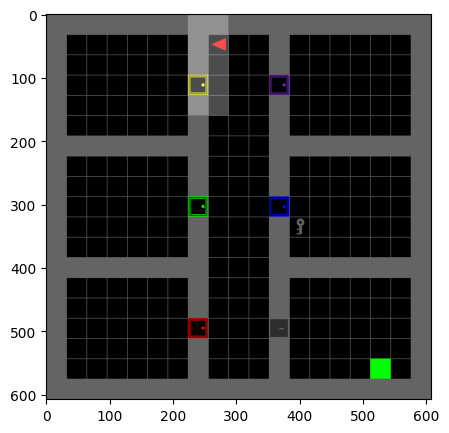

In [5]:
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

In [9]:
obs

{'image': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [4, 4, 1],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 

In [18]:
env.action_space.sample()

3